<a href="https://colab.research.google.com/github/lpoggetto/fiap_liveness/blob/main/trabalho_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!mkdir imagens

### Importando os pacotes utilizados

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')

#Exibição na mesma tela do Jupyter
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

# pacotes utilizados para tirar foto
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

ModuleNotFoundError: No module named 'mediapipe'

<IPython.core.display.Javascript object>

Saved to imagens/foto.jpg


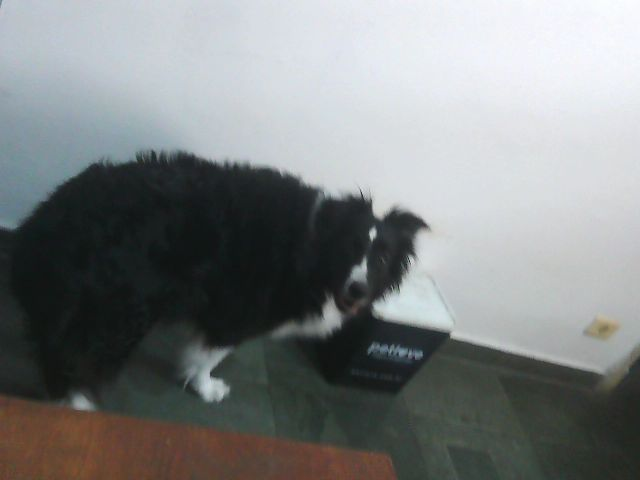

In [46]:
# funcao para tirar foto
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename = take_photo("imagens/foto.jpg")
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [47]:
# funcao para identificar rosto
face_clf = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# lendo a foto usando cv2
foto_clf = cv2.imread('imagens/foto.jpg')

# manipulando cores - BGR -> RGBimagens
foto_original = cv2.cvtColor(foto_clf, cv2.COLOR_BGR2RGB)

# manipulando cores - BGR -> gray
foto_gray = cv2.cvtColor(foto_clf, cv2.COLOR_BGR2GRAY)

In [48]:
def identificar_rosto_rgb(imagem):

    imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    faces = face_clf.detectMultiScale(imagem_gray, 1.2, 5)

    for (x,y,w,h) in faces:
        cv2.rectangle(imagem, (x,y), (x+w,y+h), (255,255,0), 2)

    return imagem

Text(0.5, 1.0, 'Imagem com rosto')

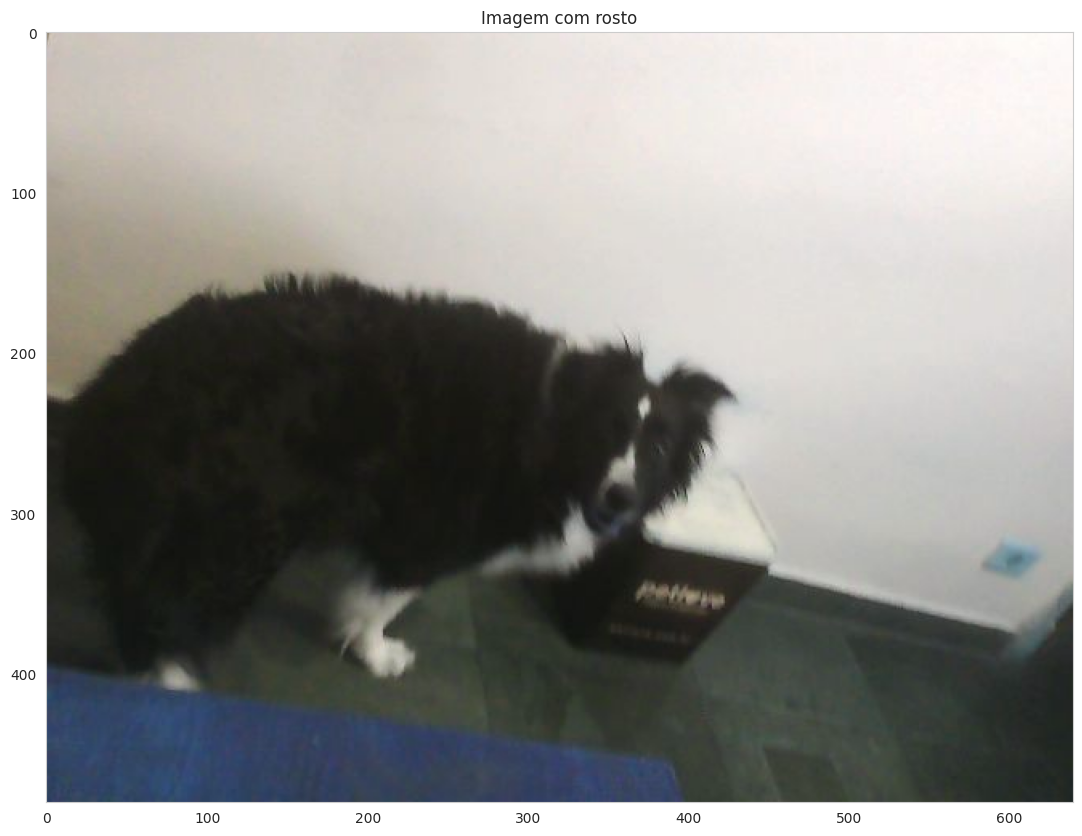

In [49]:
imagem = cv2.imread("imagens/foto.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
imagem_rosto = identificar_rosto_rgb(foto_clf)

plt.figure(figsize=(20,10))
plt.imshow(imagem_rosto, cmap="gray")
plt.title("Imagem com rosto")